#                                    --> PIPELINE PROJECT <--

In [2]:
# importar modulos necesarios

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

1. Acquisition

In [16]:
# cargar el dataset elegido

avocados = pd.read_csv('avocado.csv')


In [17]:
avocados.shape

(18249, 14)

2. Wrangling

In [18]:
# comprobar los datos nulos del data set

avocados.isnull().sum()  # No hay nulos en ninguna columna

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [19]:
avocados.columns

Index(['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region'],
      dtype='object')

In [21]:
# Comprobar que no hay duplicados
before = len(avocados)

select_columns = ['Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region']

avocados = avocados[select_columns].drop_duplicates()

after = len(avocados)

print('Numero de registros duplicados: ', str(before - after))

Numero de registros duplicados:  0


In [23]:
# Extraer el mes de la columna fecha y desechar el resto
month = []
for e in avocados["Date"]:
    aux= e.split("-")
    month.append(aux[1])
    
avocados['month'] = pd.Series(month, index=avocados.index) # Añadir columna Month al dataframe
avocados['Total Volume']= (avocados['Total Volume']/1000)

In [24]:
# Cambio del orden de las columnas

column_order = ['region','year','month','type','AveragePrice','Total Volume','4046','4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']

avocados = avocados[column_order]

In [25]:
# comprobar el tipo de datos de las columnas. cambiar year a objeto

avocados['year'] = avocados['year'].astype('object') 

In [27]:
# renombrar algunas columnas

avocados.columns = ['Region','Year','Month','Variety','Avg Price','Total Volume-k',
                    'S-M size','L size','XL size','Total Bags','S bags','L bags','XL bags']

In [28]:
# Guardo un csv con los datos manipulados

avocados.to_csv('manipulated_avocados.csv',index=False)

3.Analysis

HIPÓTESIS:
- La variedad de aguacate convencional tendrá un precio medio inferior al aguacate orgánico.
- Las regiones donde el precio medio sea más alto presentarán un volument total de venta menor
- El % que aporten al volumen total (aguacates S-M, aguacates L, aguacares XL y bolsas (mezcla tamaños) tendrán relación con el precio medio.


In [30]:
# Dado que del año 2018 solo hay registros hasta marzo voy a eliminar esos datos
filteredyear = list(avocados[(avocados['Year']==2018)].index) 
avocados = avocados.drop(filteredyear, axis=0)


In [31]:
# Las regiones vienen reflejadas todas juntas de varias maneras: Total US, grandes regiones y por estados.
# Voy a separar en 3 dataframe: Uno de regiones, otro del total y otro de ciudades

avocados_region = avocados[(avocados['Region'] == 'Plains')|(avocados['Region'] =='West')|
                    (avocados['Region'] =='California')|(avocados['Region'] =='SouthCentral')|
                    (avocados['Region'] =='Northeast')|(avocados['Region'] =='Southeast')|
                    (avocados['Region'] =='GreatLakes')|(avocados['Region'] =='Midsouth')]
avocados_totalUS = avocados[(avocados['Region'] == 'TotalUS')]

avocados_cities= avocados[(avocados['Region'] != 'Plains')|(avocados['Region'] !='West')|
                    (avocados['Region'] !='California')|(avocados['Region'] !='SouthCentral')|
                    (avocados['Region'] !='Northeast')|(avocados['Region'] !='Southeast')|
                    (avocados['Region'] !='GreatLakes')|(avocados['Region'] !='Midsouth')|
                   (avocados['Region'] != 'TotalUS')]

In [32]:
#VARIEDAD vs AVG PRICE (En todo US)

variedad_precio =avocados_region.groupby(['Variety','Year'])['Avg Price'].describe()
variedad_precio 
# Efectivamente el aguacate orgánico es más caro que el convencional. 
# Por año se observa que se ha incrementado el precio medio en 2017. Aunque no es lineal, en 2016 disminuyó.

count      mean       std   min     25%    50%     75%  \
Variety      Year                                                           
conventional 2015  416.0  1.043269  0.134133  0.69  0.9600  1.070  1.1400   
             2016  416.0  1.083293  0.224582  0.62  0.9275  1.060  1.2200   
             2017  424.0  1.262500  0.270591  0.62  1.0575  1.290  1.4300   
organic      2015  416.0  1.641635  0.205231  1.10  1.5000  1.650  1.8000   
             2016  416.0  1.523125  0.266058  0.91  1.3500  1.500  1.6800   
             2017  424.0  1.674646  0.327126  0.83  1.5000  1.675  1.8725   

                    max  
Variety      Year        
conventional 2015  1.36  
             2016  1.72  
             2017  1.98  
organic      2015  2.12  
             2016  2.58  
             2017  2.54

In [33]:
#VARIEDAD vs AVG PRICE (por regiones y año)

variedad_precio_region = pd.pivot_table(avocados_region, values=['Avg Price'], index=['Region'], columns=['Year'])

variedad_precio_region

Avg Price                    
Year              2015      2016      2017
Region                                    
California    1.315865  1.329904  1.533868
GreatLakes    1.326250  1.277019  1.424623
Midsouth      1.351346  1.350865  1.520566
Northeast     1.543750  1.595673  1.694057
Plains        1.437885  1.377500  1.510472
SouthCentral  1.112019  1.026923  1.162830
Southeast     1.414712  1.286923  1.512170
West          1.237788  1.180865  1.390000

In [34]:
# VARIEDAD vs. TOTAL VOLUMEN (todo US por año y mes)

year_month_volume = pd.pivot_table(avocados_totalUS, values=['Total Volume-k'], index=['Month'], columns=['Year'])

year_month_volume

Total Volume-k                      
Year            2015       2016       2017
Month                                     
01         15.056690  17.911825  20.146189
02         17.187930  20.195852  22.271690
03         15.875731  18.460859  16.959642
04         16.319062  18.992008  18.529214
05         18.275215  21.181417  20.079844
06         18.038011  19.373185  19.387646
07         16.886107  17.675857  17.995508
08         15.819182  17.484918  16.029801
09         15.532228  17.093090  13.449381
10         14.403881  13.577552  13.669753
11         13.871963  12.238276  15.295848
12         13.930380  15.623392  17.349612

In [35]:
#VARIEDAD vs TOTALVOLUME (por regiones y año)

variedad_volumen_region = pd.pivot_table(avocados_region, values=['Total Volume-k'], index=['Region'], columns=['Year'])

variedad_volumen_region

Total Volume-k                    
Year                   2015      2016      2017
Region                                         
California         2.898148  3.136427  2.996646
GreatLakes         1.628731  1.709039  1.786357
Midsouth           1.348288  1.483274  1.561826
Northeast          1.955567  2.105107  2.119314
Plains             0.842681  0.915785  0.946038
SouthCentral       2.792833  2.924026  3.070025
Southeast          1.539377  1.905014  1.856012
West               2.929522  3.313244  3.255230

In [47]:
avocados_region['Total_profit-k']= (avocados_region['Avg Price']*avocados_region['Total Volume-k'])
total_profit_region = pd.pivot_table(avocados_region, values=['Total_profit-k'], index=['Region'], columns=['Year'])
total_profit_region

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Total_profit-k                    
Year                   2015      2016      2017
Region                                         
California         2.971945  3.223199  3.648819
GreatLakes         1.771271  1.929401  2.296733
Midsouth           1.524706  1.747238  2.069038
Northeast          2.386314  2.737640  3.208183
Plains             0.914691  1.011460  1.212488
SouthCentral       2.280040  2.484788  2.877357
Southeast          1.656649  1.978274  2.424726
West               2.804241  3.011586  3.491055

In [39]:
total_volumen_region = pd.pivot_table(avocados_region, values=['Total_profit-k','Total Volume-k'], index=['Region'], columns=['Year'])
total_volumen_region

Total Volume-k                     Total_profit-k            \
Year                   2015      2016      2017           2015      2016   
Region                                                                     
California         2.898148  3.136427  2.996646       2.971945  3.223199   
GreatLakes         1.628731  1.709039  1.786357       1.771271  1.929401   
Midsouth           1.348288  1.483274  1.561826       1.524706  1.747238   
Northeast          1.955567  2.105107  2.119314       2.386314  2.737640   
Plains             0.842681  0.915785  0.946038       0.914691  1.011460   
SouthCentral       2.792833  2.924026  3.070025       2.280040  2.484788   
Southeast          1.539377  1.905014  1.856012       1.656649  1.978274   
West               2.929522  3.313244  3.255230       2.804241  3.011586   

                        
Year              2017  
Region                  
California    3.648819  
GreatLakes    2.296733  
Midsouth      2.069038  
Northeast     3.208183  
Plains        1.212488  
SouthCentral  2.877357  
Southeast     2.424726  
West          3.491055

In [40]:
correlacion1 = avocados_region['Total Volume-k'].corr(avocados_region['Avg Price'])
correlacion1

-0.7170661080409119

In [48]:
new_columns = ['perc_S-M size','perc_L size','perc_XL size','perc_Bags','perc_S bags','perc_L bags','perc_XL bags']
origin_columns = ['S-M size','L size','XL size','Total Bags','S bags','L bags','XL bags']
for n, o in zip(new_columns, origin_columns):
    avocados_region[n] = (avocados_region[o]/avocados_region['Total Volume-k'])/10

percen_vol= avocados_region[['Region','Year','perc_S-M size','perc_L size','perc_XL size','perc_Bags']].copy()
percen_vol = pd.pivot_table(percen_vol, values=['perc_S-M size','perc_L size','perc_XL size','perc_Bags'], index=['Region'],columns=['Year'])

print("Porcentajes de aporte al volumen total:\n{}".format(percen_vol))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Porcentajes de aporte al volumen total:
                 perc_Bags                               perc_L size  \
Year                  2015          2016          2017          2015   
Region                                                                 
California    12546.564357  33699.922313  35279.525013  41422.904000   
GreatLakes    19446.003519  33577.079586  48072.324186  64178.660168   
Midsouth      27612.083052  38437.343991  48691.445443  49100.922140   
Northeast     40242.099586  47562.063521  48779.837778  53723.788684   
Plains        26483.269795  35081.325188  45508.919278  40246.485820   
SouthCentral  23949.810373  41335.973861  49738.897614  19780.904891   
Southeast     28985.372770  44152.854016  50020.007269  18818.865413   
West          22095.396642  43014.621094  51815.358154  39061.180583   

                                         perc_S-M size                \
Year                  2016          2017          2015          2016   
Region                 

4. Visualizacion

Text(0.5, 1.0, 'Total volumen de venta por mes (2015, 2016 y 2017)\n')

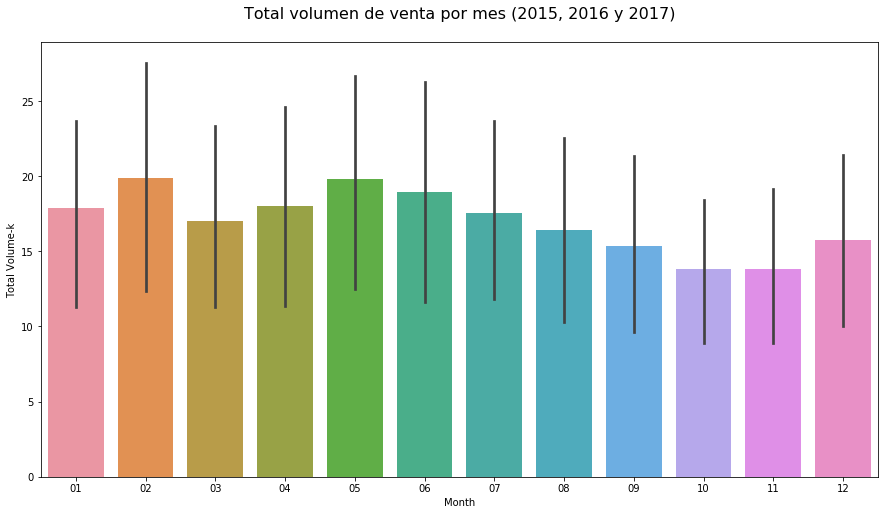

In [49]:
import matplotlib.pyplot as plt  
    
title = 'Total volumen de venta por mes (2015, 2016 y 2017)'

fig, ax = plt.subplots(figsize=(15,8))
barchart = sns.barplot(data=avocados_totalUS, x=('Month'), y='Total Volume-k')
plt.title(title + "\n", fontsize=16)

Text(0.5, 1.0, 'Precio medio de venta\n')

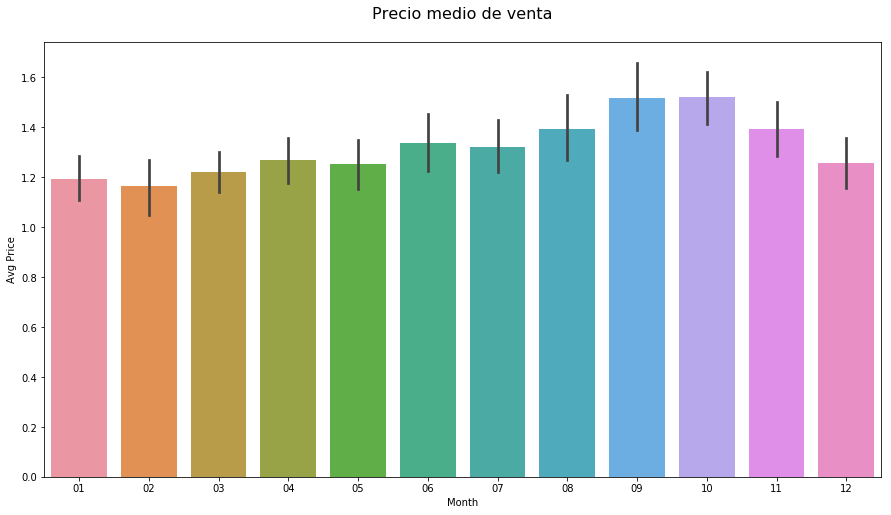

In [50]:
title = 'Precio medio de venta'

fig, ax = plt.subplots(figsize=(15,8))
barchart = sns.barplot(data=avocados_totalUS, x=('Month'), y='Avg Price')
plt.title(title + "\n", fontsize=16)

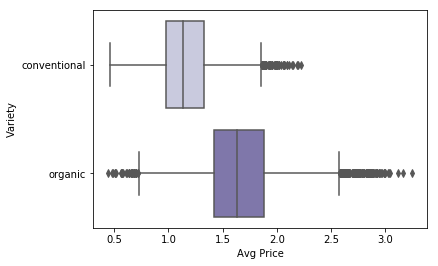

In [51]:
sns.boxplot(y="Variety", x="Avg Price", data=avocados, palette = 'Purples')